This is a notebook to process the DREAGON data set using cACGMM algorithem for BSS:

In [1]:
import io
import functools
import numpy as np
import soundfile as sf
import matplotlib
import matplotlib.pylab as plt
from IPython.display import display, Audio
from einops import rearrange
from nara_wpe.utils import stft, istft

import the algorithems used for the (not DL method) of BSS:

In [2]:
from pb_bss.distribution import CACGMMTrainer
from pb_bss.permutation_alignment import DHTVPermutationAlignment, OraclePermutationAlignment
from pb_bss.evaluation import InputMetrics, OutputMetrics

## Reading the audio files:
reading audio files from the DREGON dataset of drone recordings:

In [11]:
# THIS IS the original read method used by the BSS (blinf source seperation) study
# do we need a spacific sample rate?
# sample_rate = 8000

def soundfile_read(path):
    data, data_sample_rate = sf.read(path)
    
    # shuld I have this on?
    # assert sample_rate == data_sample_rate, (sample_rate, data_sample_rate)
    
    print(f'Read: {url}.\nSample rate: {data_sample_rate}')
    return np.ascontiguousarray(data.T)



In [12]:
free_flight_wav_file = 'C:/Users/shaig/Documents/CS_Technion/2019_b/Deep Learning Project/DL_project_2019/DREGON_dataset/DREGON_free-flight_nosource_room1/DREGON_free-flight_nosource_room1.wav'

# using SoundFile() instead of read(), because files are larger, might need to cut them for later use
with sf.SoundFile(free_flight_wav_file, mode='r') as f:
    print(f'sample rate: {f.samplerate}, channels: {f.channels} ')
    # the file is 98MB, we don't want to read it all, else we will use soundfile.read()/ sf.read()
    f.seek(10000)
    data = f.read(50000)
    
    # check if that does anithing - it does not
    data2 = np.ascontiguousarray(data.T)
    print(type(data), data.shape, type(data2), data2.shape)
    print(data.T - data2)

# print(data)

sample rate: 44100, channels: 8 
<class 'numpy.ndarray'> (50000, 8) <class 'numpy.ndarray'> (8, 50000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Some functions for plotting

In [13]:
def plot_mask(mask, *, ax=None):
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(
        mask,
        interpolation='nearest',
        vmin=0,
        vmax=1,
        origin='lower'
    )
    cbar = plt.colorbar(image, ax=ax)
    return ax

def plot_stft(stft_signal, *, ax=None):
    if ax is None:
        ax = plt.gca()
        
    stft_signal = np.abs(stft_signal)
        
    
    stft_signal = 10 * np.log10(
        np.maximum(stft_signal, np.max(stft_signal) / 1e6))
    # 1e6: 60 dB is sufficient
        
    image = ax.imshow(
        stft_signal,
        interpolation='nearest',
        origin='lower',
    )
    cbar = plt.colorbar(image, ax=ax)
    cbar.set_label('Energy / dB')
    return ax

## Transforming it into spectrograms 

f:  257 <class 'numpy.ndarray'>
t:  392 <class 'numpy.ndarray'>
data_stft:  (8, 257, 392)


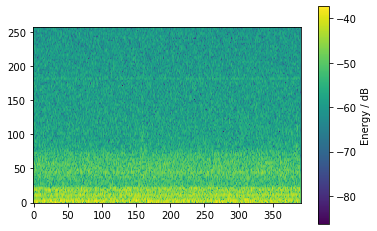

In [41]:
# instead of using the experiment stft, use scipy's implementation
from scipy import signal
# nperseg is the number of samples used for each spectrogram, (with (nperseg/2) overlap between them)
# nfft - is the number of frequancy bins used in the dft method, the number of bins will be nfft/2 + 1
# we want the channel to be the first dimention, so use .T method
f, t, data_stft = signal.stft(data.T, nperseg=256, nfft=512)
print("f: ", len(f), type(f))
print("t: ", len(t), type(t))
print("data_stft: ", data_stft.shape)

plot_stft(data_stft[0])